# **Linear Regressional Model**


                    TASHKENT WEATHER FORECAST

🌐 Fetching current weather from API...
✅ Successfully fetched current weather!

📂 Loading historical data...
✅ Loaded 139,344 rows

TRAINING ADVANCED TEMPERATURE MODEL
Creating time-series features...

📊 Data Split:
  Training: 111,456 rows (80%)
  Testing:  27,864 rows (20%)
  Train period: 2010-01-02 00:00:00 to 2022-09-19 23:00:00
  Test period:  2022-09-20 00:00:00 to 2025-11-23 23:00:00

✓ Using 27 features for prediction

📊 TRAINING METRICS:
  RMSE: 0.410°C
  MAE:  0.285°C
  R²:   0.9988

📊 TESTING METRICS:
  RMSE: 0.443°C
  MAE:  0.310°C
  R²:   0.9987

GENERATING PERFORMANCE VISUALIZATIONS


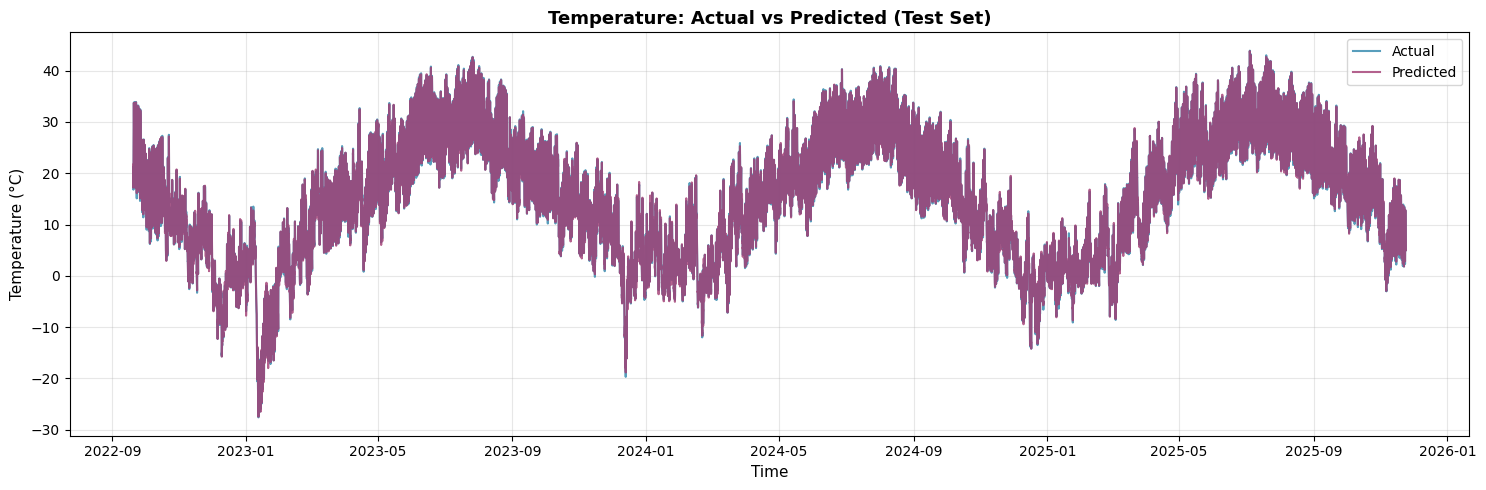

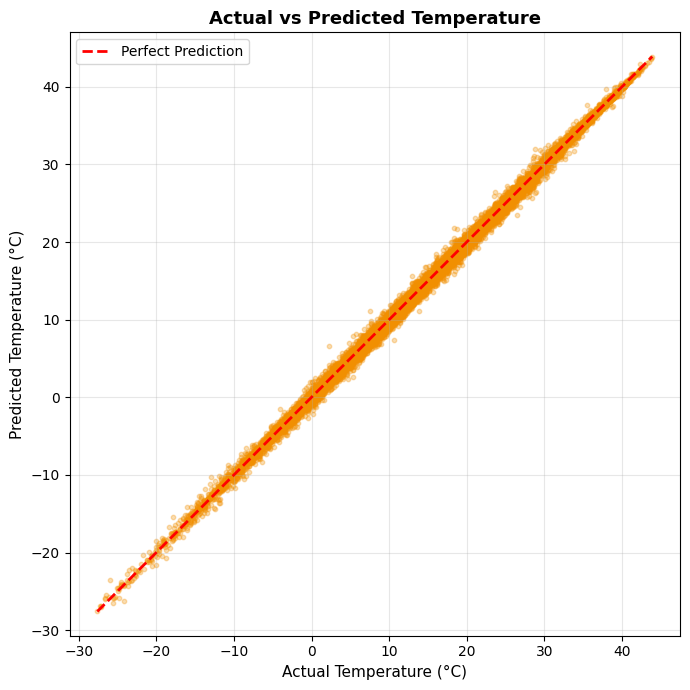

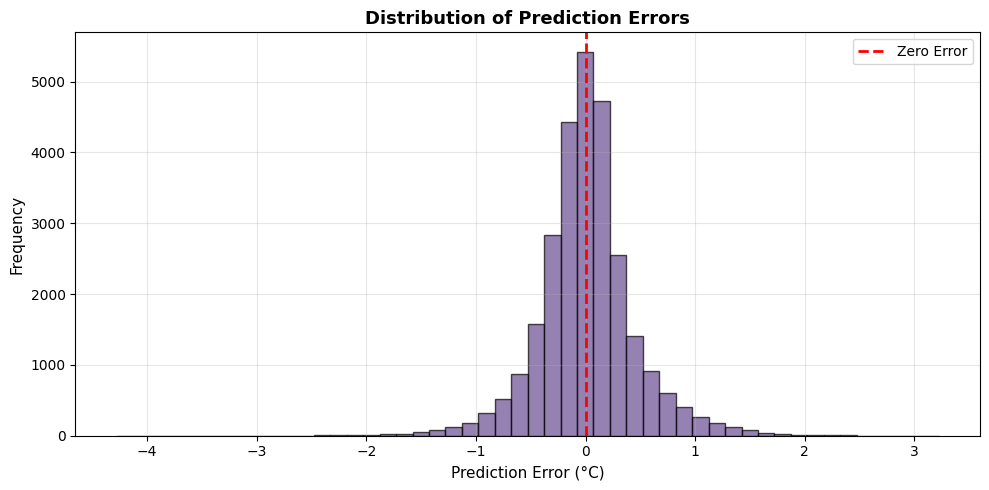

✅ Visualizations complete!

MODEL vs API COMPARISON

🌡️  Temperature Comparison:
  API (Actual):      11.84°C
  Model (Predicted): 12.48°C
  Error:             0.64°C
  Status: ✅ Excellent prediction!

🤖 Training additional prediction models...
✅ Additional models trained!

CURRENT WEATHER (REAL-TIME FROM API)
📍 City: Aktepa, UZ
🌡️  Current Temperature: 11.84°C
🤒 Feels Like: 10.05°C
❄️  Minimum Temperature: 11.84°C
🔥 Maximum Temperature: 11.84°C
💧 Humidity: 37%
🌀 Pressure: 1024 hPa
💨 Wind Speed: 1.03 m/s
🧭 Wind Direction: N (0°)
☁️  Description: smoke
🌧️  Rain Prediction: No

FUTURE TEMPERATURE PREDICTIONS (Next 5 Hours)
  🕐 15:00: 11.9°C
  🕐 16:00: 11.9°C
  🕐 17:00: 12.0°C
  🕐 18:00: 12.1°C
  🕐 19:00: 12.2°C

FUTURE HUMIDITY PREDICTIONS (Next 5 Hours)
  🕐 15:00: 37.6%
  🕐 16:00: 38.5%
  🕐 17:00: 39.5%
  🕐 18:00: 40.6%
  🕐 19:00: 41.7%

TODAY & TOMORROW DETAILED FORECAST

📅 TODAY (2025-11-29)
----------------------------------------------------------------------
  🕐 Morning      (06:00

In [29]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
import requests
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================================================
# CONFIGURATION
# ==========================================================================
API_KEY = '0ea12166dca6efaa2a7077602c59e70d'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'

# ==========================================================================
# HELPER FUNCTIONS
# ==========================================================================

def get_current_weather(lat=41.2995, lon=69.2401):
    """Fetch current weather from OpenWeatherMap API"""
    try:
        url = f"{BASE_URL}weather?lat={lat}&lon={lon}&appid={API_KEY}&units=metric"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        
        # Convert temperature if needed (sometimes API returns Kelvin despite units=metric)
        temp = data['main']['temp']
        temp_min = data['main']['temp_min']
        temp_max = data['main']['temp_max']
        feels_like = data['main']['feels_like']
        
        if temp > 100:
            temp = temp - 273.15
        if temp_min > 100:
            temp_min = temp_min - 273.15
        if temp_max > 100:
            temp_max = temp_max - 273.15
        if feels_like > 100:
            feels_like = feels_like - 273.15
        
        return {
            'city': data.get('name', 'Tashkent'),
            'country': data['sys'].get('country', 'UZ'),
            'current_temp': round(temp, 2),
            'temp_min': round(temp_min, 2),
            'temp_max': round(temp_max, 2),
            'feels_like': round(feels_like, 2),
            'humidity': data['main']['humidity'],
            'pressure': data['main']['pressure'],
            'wind_speed': data['wind']['speed'],
            'wind_gust': data['wind'].get('gust', data['wind']['speed']),
            'wind_deg': data['wind'].get('deg', 0),
            'description': data['weather'][0]['description'],
            'timestamp': datetime.now()
        }
    except Exception as e:
        print(f"❌ Error fetching weather: {e}")
        return None


def read_historical_data(filepath):
    """Load historical weather data from CSV"""
    df = pd.read_csv(filepath)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    return df


def create_features(df):
    """Create time-based and lag features for better prediction"""
    df = df.copy()
    
    # Time-based features
    if 'time' in df.columns:
        df['hour'] = df['time'].dt.hour
        df['day_of_year'] = df['time'].dt.dayofyear
        df['month'] = df['time'].dt.month
        df['day_of_week'] = df['time'].dt.dayofweek
        
        # Cyclical encoding
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Lag features
    if 'temperature_2m' in df.columns:
        for lag in [1, 3, 6, 12, 24]:
            df[f'temp_lag_{lag}h'] = df['temperature_2m'].shift(lag)
    
    if 'relative_humidity_2m' in df.columns:
        for lag in [1, 3, 6]:
            df[f'humidity_lag_{lag}h'] = df['relative_humidity_2m'].shift(lag)
    
    if 'pressure_msl' in df.columns:
        for lag in [1, 6, 12]:
            df[f'pressure_lag_{lag}h'] = df['pressure_msl'].shift(lag)
    
    # Rolling statistics
    if 'temperature_2m' in df.columns:
        df['temp_ma_3h'] = df['temperature_2m'].rolling(window=3, min_periods=1).mean()
        df['temp_ma_24h'] = df['temperature_2m'].rolling(window=24, min_periods=1).mean()
    
    df = df.dropna().reset_index(drop=True)
    return df


def prepare_rain_data(historical_data):
    """Prepare data for rain prediction"""
    historical_data['RainTomorrow'] = (historical_data['precipitation'] > 0).astype(int)
    
    features = ['temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 
                'windgusts_10m', 'pressure_msl', 'winddirection_10m']
    
    X = historical_data[features].fillna(0)
    Y = historical_data['RainTomorrow']
    
    return X, Y


def train_rain_model(X, Y):
    """Train logistic regression for rain prediction"""
    model = LogisticRegression(max_iter=1000)
    model.fit(X, Y)
    return model


def prepare_regression_data(historical_data, target_column):
    """Prepare data for temperature/humidity regression"""
    X = []
    Y = []
    
    values = historical_data[target_column].values
    
    for i in range(5, len(values)):
        X.append(values[i-5:i])
        Y.append(values[i])
    
    return np.array(X), np.array(Y)


def train_regression_model(X, Y):
    """Train linear regression model"""
    model = LinearRegression()
    model.fit(X, Y)
    return model


def predict_future(model, current_value, steps=5):
    """Predict future values"""
    predictions = []
    recent_values = [current_value] * 5
    
    for _ in range(steps):
        next_pred = model.predict([recent_values])[0]
        predictions.append(next_pred)
        recent_values = recent_values[1:] + [next_pred]
    
    return predictions


def wind_direction_to_compass(wind_deg):
    """Convert wind degree to compass direction"""
    wind_deg = wind_deg % 360
    
    compass_points = [
        ("N", 0, 11.25), ("NNE", 11.25, 33.75), ("NE", 33.75, 56.25),
        ("ENE", 56.25, 78.75), ("E", 78.75, 101.25), ("ESE", 101.25, 123.75),
        ("SE", 123.75, 146.25), ("SSE", 146.25, 168.75), ("S", 168.75, 191.25),
        ("SSW", 191.25, 213.75), ("SW", 213.75, 236.25), ("WSW", 236.25, 258.75),
        ("W", 258.75, 281.25), ("WNW", 281.25, 303.75), ("NW", 303.75, 326.25),
        ("NNW", 326.25, 348.75)
    ]
    
    for point, start, end in compass_points:
        if start <= wind_deg < end:
            return point
    return "N"


def train_advanced_model(historical_df):
    """Train model with train/test split and evaluation"""
    print("\n" + "="*70)
    print("TRAINING ADVANCED TEMPERATURE MODEL")
    print("="*70)
    
    # Create features
    print("Creating time-series features...")
    df_with_features = create_features(historical_df)
    
    # Split data: 80% train, 20% test
    split_idx = int(len(df_with_features) * 0.8)
    train_df = df_with_features.iloc[:split_idx].copy()
    test_df = df_with_features.iloc[split_idx:].copy()
    
    print(f"\n📊 Data Split:")
    print(f"  Training: {len(train_df):,} rows (80%)")
    print(f"  Testing:  {len(test_df):,} rows (20%)")
    
    if 'time' in train_df.columns:
        print(f"  Train period: {train_df['time'].min()} to {train_df['time'].max()}")
        print(f"  Test period:  {test_df['time'].min()} to {test_df['time'].max()}")
    
    # Prepare features
    exclude_cols = ['time', 'temperature_2m']
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    X_train = train_df[feature_cols].values
    y_train = train_df['temperature_2m'].values
    X_test = test_df[feature_cols].values
    y_test = test_df['temperature_2m'].values
    
    print(f"\n✓ Using {len(feature_cols)} features for prediction")
    
    # Scale and train
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"\n📊 TRAINING METRICS:")
    print(f"  RMSE: {train_rmse:.3f}°C")
    print(f"  MAE:  {train_mae:.3f}°C")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"\n📊 TESTING METRICS:")
    print(f"  RMSE: {test_rmse:.3f}°C")
    print(f"  MAE:  {test_mae:.3f}°C")
    print(f"  R²:   {test_r2:.4f}")
    
    return model, scaler, feature_cols, y_test, y_test_pred, test_df


def plot_model_performance(y_actual, y_pred, test_df):
    """Plot model performance visualizations"""
    print("\n" + "="*70)
    print("GENERATING PERFORMANCE VISUALIZATIONS")
    print("="*70)
    
    # 1. Time series: Actual vs Predicted
    plt.figure(figsize=(15, 5))
    if 'time' in test_df.columns:
        x_axis = test_df['time'].values
        plt.plot(x_axis, y_actual, label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
        plt.plot(x_axis, y_pred, label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
        plt.xlabel('Time', fontsize=11)
    else:
        x_axis = range(len(y_actual))
        plt.plot(x_axis, y_actual, label='Actual', linewidth=1.5, alpha=0.8)
        plt.plot(x_axis, y_pred, label='Predicted', linewidth=1.5, alpha=0.8)
        plt.xlabel('Sample Index', fontsize=11)
    
    plt.ylabel('Temperature (°C)', fontsize=11)
    plt.title('Temperature: Actual vs Predicted (Test Set)', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Scatter plot: Actual vs Predicted
    plt.figure(figsize=(7, 7))
    plt.scatter(y_actual, y_pred, alpha=0.3, s=10, color='#F18F01')
    
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Temperature (°C)', fontsize=11)
    plt.ylabel('Predicted Temperature (°C)', fontsize=11)
    plt.title('Actual vs Predicted Temperature', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # 3. Error distribution
    errors = y_actual - y_pred
    plt.figure(figsize=(10, 5))
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='#6A4C93')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    plt.xlabel('Prediction Error (°C)', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Distribution of Prediction Errors', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizations complete!")


def predict_current_with_model(model, scaler, feature_cols, current_weather, historical_df):
    """Compare model prediction with real API temperature"""
    print("\n" + "="*70)
    print("MODEL vs API COMPARISON")
    print("="*70)
    
    # Get recent data for lag features
    recent_data = historical_df.tail(24).copy()
    
    current_row = pd.DataFrame([{
        'time': current_weather['timestamp'],
        'temperature_2m': current_weather['current_temp'],
        'relative_humidity_2m': current_weather['humidity'],
        'pressure_msl': current_weather['pressure'],
        'windspeed_10m': current_weather['wind_speed'],
        'windgusts_10m': current_weather['wind_gust'],
        'precipitation': 0,
        'winddirection_10m': current_weather['wind_deg']
    }])
    
    temp_df = pd.concat([recent_data, current_row], ignore_index=True)
    temp_df = create_features(temp_df)
    
    missing = [col for col in feature_cols if col not in temp_df.columns]
    
    if len(missing) == 0 and len(temp_df) > 0:
        features = temp_df.iloc[-1:][feature_cols].values
        features_scaled = scaler.transform(features)
        predicted_temp = model.predict(features_scaled)[0]
        actual_temp = current_weather['current_temp']
        error = abs(predicted_temp - actual_temp)
        
        print(f"\n🌡️  Temperature Comparison:")
        print(f"  API (Actual):      {actual_temp:.2f}°C")
        print(f"  Model (Predicted): {predicted_temp:.2f}°C")
        print(f"  Error:             {error:.2f}°C")
        
        if error < 2:
            print(f"  Status: ✅ Excellent prediction!")
        elif error < 5:
            print(f"  Status: ✓ Good prediction")
        else:
            print(f"  Status: ⚠ High error")
    else:
        print(f"❌ Could not generate prediction (missing features: {missing[:3]})")


def predict_today_tomorrow(model, scaler, feature_cols, historical_df):
    """Predict today and tomorrow weather at 6, 12, 18, 24 hours"""
    print("\n" + "="*70)
    print("TODAY & TOMORROW DETAILED FORECAST")
    print("="*70)
    
    # Get recent data with features already created
    df_with_features = create_features(historical_df)
    recent_data = df_with_features.tail(100).copy()  # Get more data for better predictions
    
    # Forecast times
    forecast_hours = [6, 12, 18, 0]
    hour_names = {6: "Morning", 12: "Afternoon", 18: "Sunset", 0: "Night"}
    
    now = datetime.now()
    today = now.date()
    tomorrow = today + timedelta(days=1)
    
    forecasts = []
    
    for day_name, day_date in [("TODAY", today), ("TOMORROW", tomorrow)]:
        print(f"\n📅 {day_name} ({day_date.strftime('%Y-%m-%d')})")
        print("-" * 70)
        
        for hour in forecast_hours:
            target_time = datetime.combine(day_date, datetime.min.time()) + timedelta(hours=hour)
            is_past = target_time < now
            
            # Find the closest historical hour with similar characteristics
            target_hour = target_time.hour
            target_day_of_year = target_time.timetuple().tm_yday
            
            # Filter data for same hour of day
            same_hour_data = recent_data[recent_data['hour'] == target_hour]
            
            if len(same_hour_data) > 0:
                # Use the most recent data point with same hour
                last_row = same_hour_data.iloc[-1]
                
                # Get features for prediction
                features = last_row[feature_cols].values.reshape(1, -1)
                features_scaled = scaler.transform(features)
                predicted_temp = model.predict(features_scaled)[0]
                
                forecasts.append({
                    'day': day_name,
                    'hour': hour,
                    'period': hour_names[hour],
                    'temperature': predicted_temp,
                    'is_past': is_past
                })
                
                hour_display = "00:00" if hour == 0 else f"{hour:02d}:00"
                past_marker = " (past)" if is_past else ""
                print(f"  🕐 {hour_names[hour]:12s} ({hour_display}): {predicted_temp:.1f}°C{past_marker}")
            else:
                # Fallback: use the last available data
                last_row = recent_data.iloc[-1]
                features = last_row[feature_cols].values.reshape(1, -1)
                features_scaled = scaler.transform(features)
                predicted_temp = model.predict(features_scaled)[0]
                
                hour_display = "00:00" if hour == 0 else f"{hour:02d}:00"
                past_marker = " (past)" if is_past else ""
                print(f"  🕐 {hour_names[hour]:12s} ({hour_display}): {predicted_temp:.1f}°C{past_marker}")
    
    return forecasts


# ==========================================================================
# MAIN WEATHER VIEW
# ==========================================================================

def weather_view():
    """Main weather prediction function"""
    
    print("\n" + "="*70)
    print(" " * 20 + "TASHKENT WEATHER FORECAST")
    print("="*70)
    
    # Get current weather
    print("\n🌐 Fetching current weather from API...")
    current_weather = get_current_weather()
    
    if not current_weather:
        print("❌ Failed to fetch current weather")
        return
    
    print("✅ Successfully fetched current weather!")
    
    # Load historical data
    print("\n📂 Loading historical data...")
    historical_data = read_historical_data('./data/tashkent_weather_15years.csv')
    print(f"✅ Loaded {len(historical_data):,} rows")
    
    # Train advanced model with evaluation
    model, scaler, feature_cols, y_test, y_test_pred, test_df = train_advanced_model(historical_data)
    
    # Visualize model performance
    plot_model_performance(y_test, y_test_pred, test_df)
    
    # Compare model with current API temperature
    predict_current_with_model(model, scaler, feature_cols, current_weather, historical_data)
    
    # Train additional models for hourly predictions
    print("\n🤖 Training additional prediction models...")
    X_rain, Y_rain = prepare_rain_data(historical_data)
    rain_model = train_rain_model(X_rain, Y_rain)
    
    X_temp, Y_temp = prepare_regression_data(historical_data, 'temperature_2m')
    temp_model = train_regression_model(X_temp, Y_temp)
    
    X_hum, Y_hum = prepare_regression_data(historical_data, 'relative_humidity_2m')
    hum_model = train_regression_model(X_hum, Y_hum)
    print("✅ Additional models trained!")
    
    # Get compass direction
    compass_direction = wind_direction_to_compass(current_weather['wind_deg'])
    
    # Predict rain
    current_rain_data = pd.DataFrame([{
        'temperature_2m': current_weather['current_temp'],
        'relative_humidity_2m': current_weather['humidity'],
        'windspeed_10m': current_weather['wind_speed'],
        'windgusts_10m': current_weather['wind_gust'],
        'pressure_msl': current_weather['pressure'],
        'winddirection_10m': current_weather['wind_deg']
    }])
    
    rain_prediction = rain_model.predict(current_rain_data)[0]
    
    # Predict future hourly values
    future_temp = predict_future(temp_model, current_weather['current_temp'])
    future_humidity = predict_future(hum_model, current_weather['humidity'])
    
    # Generate times
    timezone = pytz.timezone('Asia/Tashkent')
    now = datetime.now(timezone)
    next_hour = now + timedelta(hours=1)
    next_hour = next_hour.replace(minute=0, second=0, microsecond=0)
    
    future_times = [(next_hour + timedelta(hours=i)).strftime("%H:00") for i in range(5)]
    
    # Display current weather
    print("\n" + "="*70)
    print("CURRENT WEATHER (REAL-TIME FROM API)")
    print("="*70)
    print(f"📍 City: {current_weather['city']}, {current_weather['country']}")
    print(f"🌡️  Current Temperature: {current_weather['current_temp']}°C")
    print(f"🤒 Feels Like: {current_weather['feels_like']}°C")
    print(f"❄️  Minimum Temperature: {current_weather['temp_min']}°C")
    print(f"🔥 Maximum Temperature: {current_weather['temp_max']}°C")
    print(f"💧 Humidity: {current_weather['humidity']}%")
    print(f"🌀 Pressure: {current_weather['pressure']} hPa")
    print(f"💨 Wind Speed: {current_weather['wind_speed']} m/s")
    print(f"🧭 Wind Direction: {compass_direction} ({current_weather['wind_deg']}°)")
    print(f"☁️  Description: {current_weather['description']}")
    print(f"🌧️  Rain Prediction: {'Yes' if rain_prediction else 'No'}")
    
    # Future predictions (next 5 hours)
    print("\n" + "="*70)
    print("FUTURE TEMPERATURE PREDICTIONS (Next 5 Hours)")
    print("="*70)
    for time, temp in zip(future_times, future_temp):
        print(f"  🕐 {time}: {round(temp, 1)}°C")
    
    print("\n" + "="*70)
    print("FUTURE HUMIDITY PREDICTIONS (Next 5 Hours)")
    print("="*70)
    for time, humidity in zip(future_times, future_humidity):
        print(f"  🕐 {time}: {round(humidity, 1)}%")
    
    # Today & Tomorrow forecast
    forecasts = predict_today_tomorrow(model, scaler, feature_cols, historical_data)
    
    print("\n" + "="*70)
    print("✅ FORECAST COMPLETE!")
    print("="*70)


# Run the weather view
if __name__ == "__main__":
    weather_view()

# **Tensorflow Time series Sequence Model**

2025-11-29 19:37:57.256623: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 19:37:57.470664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-29 19:37:58.629780: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



               LSTM TIME SERIES WEATHER FORECASTING
                  Sequential Model (From Scratch)

LOADING WEATHER DATA FOR LSTM MODEL
✓ Loaded 139,344 rows
✓ Date range: 2010-01-01 00:00:00 to 2025-11-23 23:00:00
✓ Columns: ['time', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'windspeed_10m', 'windgusts_10m', 'pressure_msl', 'winddirection_10m']

PREPARING TIME SERIES SEQUENCES
✓ Created 139,320 sequences
✓ Input shape: (139320, 24, 6) (samples, timesteps, features)
✓ Output shape: (139320,)
✓ Sequence length: 24 hours

SEQUENTIAL DATA SPLIT (80/20)
✓ Training samples: 111,456 (80%)
✓ Testing samples:  27,864 (20%)

BUILDING LSTM NEURAL NETWORK FROM SCRATCH


I0000 00:00:1764427082.222732   16588 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/shaxzod/University/AI/AI_Porject/myenv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

None
✓ Model built successfully!

TRAINING LSTM MODEL
Epoch 1/50


2025-11-29 19:38:04.278383: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


1742/1742 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0038 - mae: 0.0457 - val_loss: 6.6731e-04 - val_mae: 0.0199
Epoch 2/50
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 3.0289e-04 - val_mae: 0.0133
Epoch 3/50
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 6.3108e-04 - mae: 0.0193 - val_loss: 2.1812e-04 - val_mae: 0.0113
Epoch 4/50
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 4.5398e-04 - mae: 0.0163 - val_loss: 1.6826e-04 - val_mae: 0.0097
Epoch 5/50
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 3.9069e-04 - mae: 0.0151 - val_loss: 1.7577e-04 - val_mae: 0.0101
Epoch 6/50
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 3.6422e-04 - mae: 0.0145 - val_loss: 2.2336e-04 - val_mae: 0.0115
Epoch 7/50
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 3.4575e-04 - mae: 0.0141 - val_loss: 2.3873e-04 - val_mae: 0.0123
Epoch 8/50
1742/1742 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 3.3021e-04 - mae: 0.0137 - val_loss: 1.3979e-04

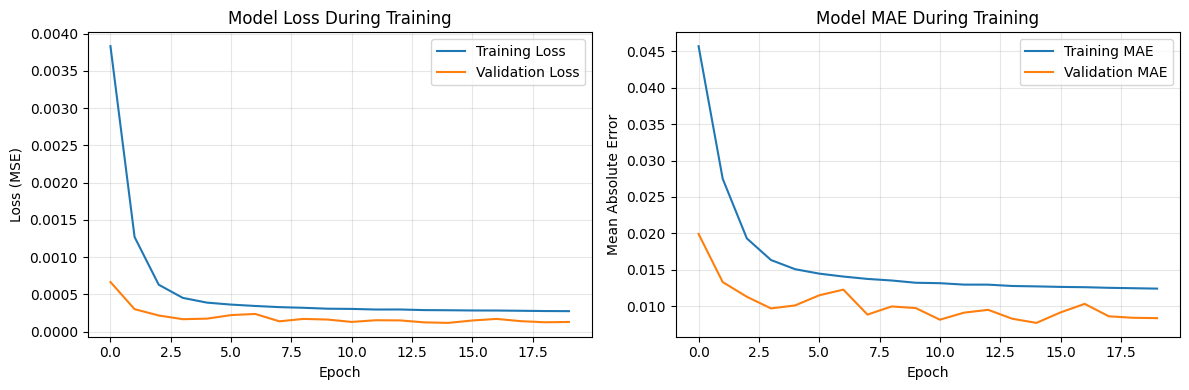

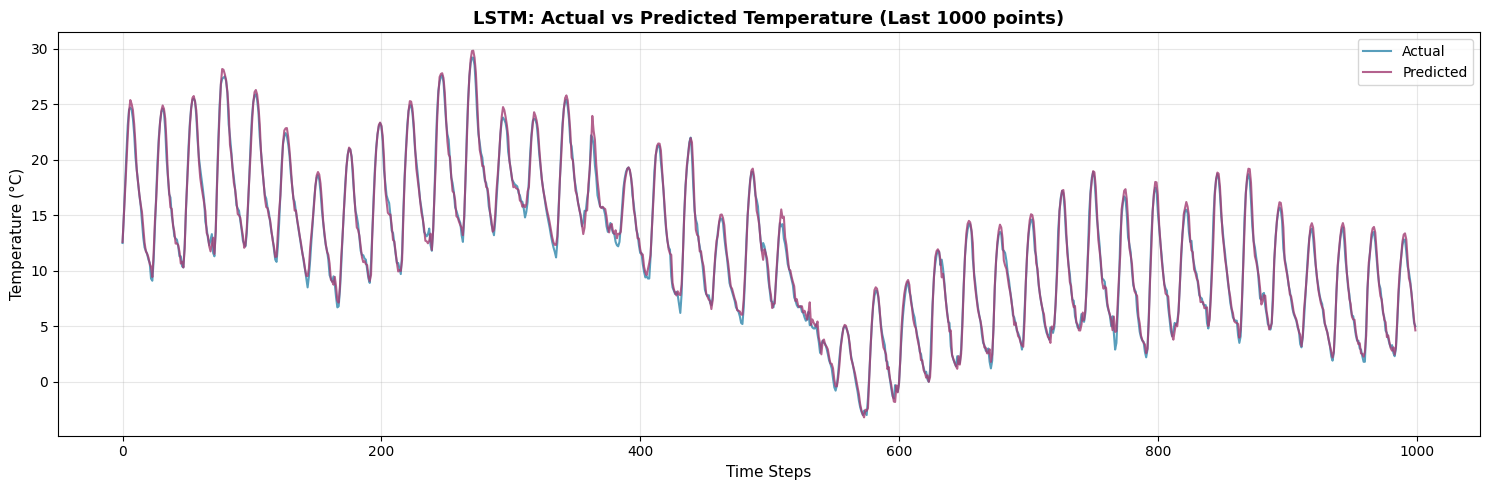

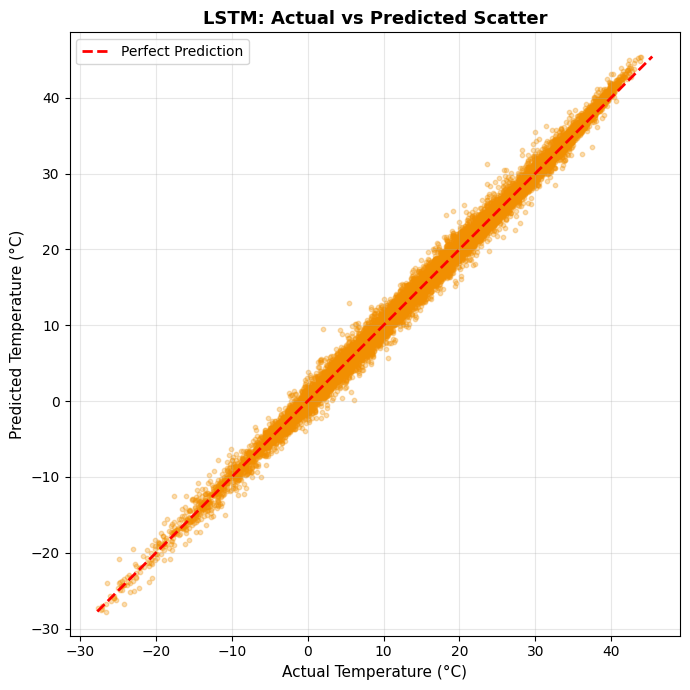


FORECASTING NEXT 48 HOURS
✓ Generated 48 hourly predictions

48-HOUR TEMPERATURE FORECAST

📅 2025-11-24 (Monday)
----------------------------------------------------------------------
  🕐 00:00 (Night       ): 4.6°C
  🕐 06:00 (Morning     ): 1.9°C
  🕐 12:00 (Afternoon   ): 12.1°C
  🕐 18:00 (Sunset      ): 15.9°C

📅 2025-11-25 (Tuesday)
----------------------------------------------------------------------
  🕐 00:00 (Night       ): 9.0°C
  🕐 06:00 (Morning     ): 5.0°C
  🕐 12:00 (Afternoon   ): 9.8°C
  🕐 18:00 (Sunset      ): 18.4°C

✅ LSTM FORECASTING COMPLETE!


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests

# For neural network - we'll use Keras/TensorFlow but train from scratch
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================================================
# CONFIGURATION
# ==========================================================================
API_KEY = '0ea12166dca6efaa2a7077602c59e70d'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'
DATA_PATH = './data/tashkent_weather_15years.csv'

# LSTM Parameters
SEQUENCE_LENGTH = 24  # Use last 24 hours to predict next hour
EPOCHS = 50
BATCH_SIZE = 64

# ==========================================================================
# DATA LOADING
# ==========================================================================

def load_weather_data(filepath):
    """Load historical weather data"""
    print("\n" + "="*70)
    print("LOADING WEATHER DATA FOR LSTM MODEL")
    print("="*70)
    
    df = pd.read_csv(filepath)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    
    print(f"✓ Loaded {len(df):,} rows")
    print(f"✓ Date range: {df['time'].min()} to {df['time'].max()}")
    print(f"✓ Columns: {list(df.columns)}")
    
    return df


def prepare_sequences(data, sequence_length=24):
    """
    Prepare sequences for LSTM training
    Uses sliding window approach: each sequence is 24 hours, predicts next hour
    """
    print("\n" + "="*70)
    print("PREPARING TIME SERIES SEQUENCES")
    print("="*70)
    
    # Select features for prediction
    feature_cols = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 
                    'windspeed_10m', 'windgusts_10m', 'precipitation']
    
    # Extract feature data
    feature_data = data[feature_cols].values
    
    # Normalize data to 0-1 range (important for neural networks)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(feature_data)
    
    # Create sequences using sliding window
    X = []  # Input sequences (past 24 hours)
    y = []  # Target values (next hour temperature)
    
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])  # Past 24 hours, all features
        y.append(scaled_data[i, 0])  # Next hour temperature (first column)
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"✓ Created {len(X):,} sequences")
    print(f"✓ Input shape: {X.shape} (samples, timesteps, features)")
    print(f"✓ Output shape: {y.shape}")
    print(f"✓ Sequence length: {sequence_length} hours")
    
    return X, y, scaler, feature_cols


def train_test_split_sequential(X, y, train_ratio=0.8):
    """Split data sequentially for time series"""
    split_idx = int(len(X) * train_ratio)
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    print("\n" + "="*70)
    print("SEQUENTIAL DATA SPLIT (80/20)")
    print("="*70)
    print(f"✓ Training samples: {len(X_train):,} ({train_ratio*100:.0f}%)")
    print(f"✓ Testing samples:  {len(X_test):,} ({(1-train_ratio)*100:.0f}%)")
    
    return X_train, X_test, y_train, y_test


# ==========================================================================
# LSTM MODEL BUILDING
# ==========================================================================

def build_lstm_model(input_shape):
    """
    Build LSTM neural network from scratch
    Architecture:
    - LSTM layer 1: 50 units (learns patterns from sequences)
    - Dropout: 20% (prevents overfitting)
    - LSTM layer 2: 50 units (deeper pattern recognition)
    - Dropout: 20%
    - Dense output: 1 unit (temperature prediction)
    """
    print("\n" + "="*70)
    print("BUILDING LSTM NEURAL NETWORK FROM SCRATCH")
    print("="*70)
    
    model = Sequential([
        # First LSTM layer - returns sequences for next layer
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),  # Randomly drop 20% of neurons during training
        
        # Second LSTM layer - deeper learning
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        
        # Output layer - single temperature prediction
        Dense(1)
    ])
    
    # Compile model with optimizer and loss function
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    print(model.summary())
    print("✓ Model built successfully!")
    
    return model


def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=64):
    """Train LSTM model with early stopping"""
    print("\n" + "="*70)
    print("TRAINING LSTM MODEL")
    print("="*70)
    
    # Early stopping: stop training if validation loss doesn't improve
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    
    print("\n✓ Training complete!")
    
    return model, history


def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    """Evaluate model performance"""
    print("\n" + "="*70)
    print("EVALUATING MODEL PERFORMANCE")
    print("="*70)
    
    # Make predictions
    y_train_pred = model.predict(X_train, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)
    
    # Create dummy arrays for inverse transform (scaler needs all features)
    dummy_train = np.zeros((len(y_train_pred), 6))
    dummy_train[:, 0] = y_train_pred.flatten()
    dummy_test = np.zeros((len(y_test_pred), 6))
    dummy_test[:, 0] = y_test_pred.flatten()
    
    dummy_train_actual = np.zeros((len(y_train), 6))
    dummy_train_actual[:, 0] = y_train
    dummy_test_actual = np.zeros((len(y_test), 6))
    dummy_test_actual[:, 0] = y_test
    
    # Inverse transform to get actual temperatures
    y_train_pred_actual = scaler.inverse_transform(dummy_train)[:, 0]
    y_test_pred_actual = scaler.inverse_transform(dummy_test)[:, 0]
    y_train_actual = scaler.inverse_transform(dummy_train_actual)[:, 0]
    y_test_actual = scaler.inverse_transform(dummy_test_actual)[:, 0]
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))
    train_mae = mean_absolute_error(y_train_actual, y_train_pred_actual)
    train_r2 = r2_score(y_train_actual, y_train_pred_actual)
    
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
    test_mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
    test_r2 = r2_score(y_test_actual, y_test_pred_actual)
    
    print(f"\n📊 TRAINING METRICS:")
    print(f"  RMSE: {train_rmse:.3f}°C")
    print(f"  MAE:  {train_mae:.3f}°C")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"\n📊 TESTING METRICS:")
    print(f"  RMSE: {test_rmse:.3f}°C")
    print(f"  MAE:  {test_mae:.3f}°C")
    print(f"  R²:   {test_r2:.4f}")
    
    return y_test_actual, y_test_pred_actual


# ==========================================================================
# VISUALIZATION
# ==========================================================================

def plot_training_history(history):
    """Plot training and validation loss"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Model Loss During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Model MAE During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_predictions(y_actual, y_pred):
    """Plot actual vs predicted temperatures"""
    plt.figure(figsize=(15, 5))
    
    # Plot only last 1000 points for clarity
    n = min(1000, len(y_actual))
    x = range(n)
    
    plt.plot(x, y_actual[-n:], label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
    plt.plot(x, y_pred[-n:], label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
    plt.xlabel('Time Steps', fontsize=11)
    plt.ylabel('Temperature (°C)', fontsize=11)
    plt.title('LSTM: Actual vs Predicted Temperature (Last 1000 points)', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Scatter plot
    plt.figure(figsize=(7, 7))
    plt.scatter(y_actual, y_pred, alpha=0.3, s=10, color='#F18F01')
    
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Temperature (°C)', fontsize=11)
    plt.ylabel('Predicted Temperature (°C)', fontsize=11)
    plt.title('LSTM: Actual vs Predicted Scatter', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


# ==========================================================================
# FORECASTING
# ==========================================================================

def forecast_future(model, last_sequence, scaler, hours=48):
    """Forecast future temperatures using LSTM"""
    print("\n" + "="*70)
    print(f"FORECASTING NEXT {hours} HOURS")
    print("="*70)
    
    predictions = []
    current_sequence = last_sequence.copy()
    
    for h in range(hours):
        # Predict next hour
        next_pred = model.predict(current_sequence.reshape(1, *current_sequence.shape), verbose=0)
        
        # Inverse transform to get actual temperature
        dummy = np.zeros((1, 6))
        dummy[0, 0] = next_pred[0, 0]
        temp = scaler.inverse_transform(dummy)[0, 0]
        
        predictions.append(temp)
        
        # Update sequence: remove oldest, add newest prediction
        new_row = current_sequence[-1].copy()
        new_row[0] = next_pred[0, 0]  # Update temperature
        
        current_sequence = np.vstack([current_sequence[1:], new_row])
    
    print(f"✓ Generated {len(predictions)} hourly predictions")
    
    return predictions


def display_forecast(predictions, start_time):
    """Display forecast in readable format"""
    print("\n" + "="*70)
    print("48-HOUR TEMPERATURE FORECAST")
    print("="*70)
    
    # Group by day
    current_date = None
    
    for i, temp in enumerate(predictions):
        forecast_time = start_time + timedelta(hours=i+1)
        
        if forecast_time.date() != current_date:
            current_date = forecast_time.date()
            print(f"\n📅 {current_date.strftime('%Y-%m-%d (%A)')}")
            print("-" * 70)
        
        hour_str = forecast_time.strftime('%H:%M')
        
        # Highlight specific times
        if forecast_time.hour in [6, 12, 18, 0]:
            period = {6: "Morning", 12: "Afternoon", 18: "Sunset", 0: "Night"}[forecast_time.hour]
            print(f"  🕐 {hour_str} ({period:12s}): {temp:.1f}°C")


# ==========================================================================
# MAIN EXECUTION
# ==========================================================================

def main():
    """Main execution function"""
    print("\n" + "="*70)
    print(" " * 15 + "LSTM TIME SERIES WEATHER FORECASTING")
    print(" " * 18 + "Sequential Model (From Scratch)")
    print("="*70)
    
    # 1. Load data
    df = load_weather_data(DATA_PATH)
    
    # 2. Prepare sequences
    X, y, scaler, feature_cols = prepare_sequences(df, sequence_length=SEQUENCE_LENGTH)
    
    # 3. Split data
    X_train, X_test, y_train, y_test = train_test_split_sequential(X, y)
    
    # 4. Build model
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    # 5. Train model
    model, history = train_lstm_model(model, X_train, y_train, X_test, y_test, 
                                     epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    # 6. Evaluate
    y_test_actual, y_test_pred = evaluate_model(model, X_train, y_train, X_test, y_test, scaler)
    
    # 7. Visualize
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70)
    
    plot_training_history(history)
    plot_predictions(y_test_actual, y_test_pred)
    
    # 8. Forecast future
    last_sequence = X[-1]  # Last 24 hours from dataset
    predictions = forecast_future(model, last_sequence, scaler, hours=48)
    
    # 9. Display forecast
    last_time = df['time'].max()
    display_forecast(predictions, last_time)
    
    print("\n" + "="*70)
    print("✅ LSTM FORECASTING COMPLETE!")
    print("="*70)
    
    return model, scaler, history


if __name__ == "__main__":
    model, scaler, history = main()

# **Pytorch Time series lstm model**


            PYTORCH LSTM TIME SERIES WEATHER FORECASTING
                  Sequential Model (From Scratch)

LOADING WEATHER DATA FOR PYTORCH LSTM MODEL
✓ Loaded 139,344 rows
✓ Date range: 2010-01-01 00:00:00 to 2025-11-23 23:00:00
✓ Columns: ['time', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'windspeed_10m', 'windgusts_10m', 'pressure_msl', 'winddirection_10m']

PREPARING TIME SERIES SEQUENCES
✓ Created 139,320 sequences
✓ Input shape: (139320, 24, 6) (samples, timesteps, features)
✓ Output shape: (139320,)
✓ Sequence length: 24 hours

SEQUENTIAL DATA SPLIT (80/20)
✓ Training samples: 111,456 (80%)
✓ Testing samples:  27,864 (20%)

BUILDING PYTORCH LSTM MODEL
✓ Model built successfully!
  Input size: 6 features
  Hidden size: 50
  Num layers: 2
  Dropout: 0.2
  Parameters: 32,051

TRAINING PYTORCH LSTM MODEL
Device: cuda
Epoch [5/50] - Train Loss: 0.000647, Train MAE: 0.019719 | Test Loss: 0.000805, Test MAE: 0.022060
Epoch [10/50] - Train Loss: 0.000364, Train MAE: 0

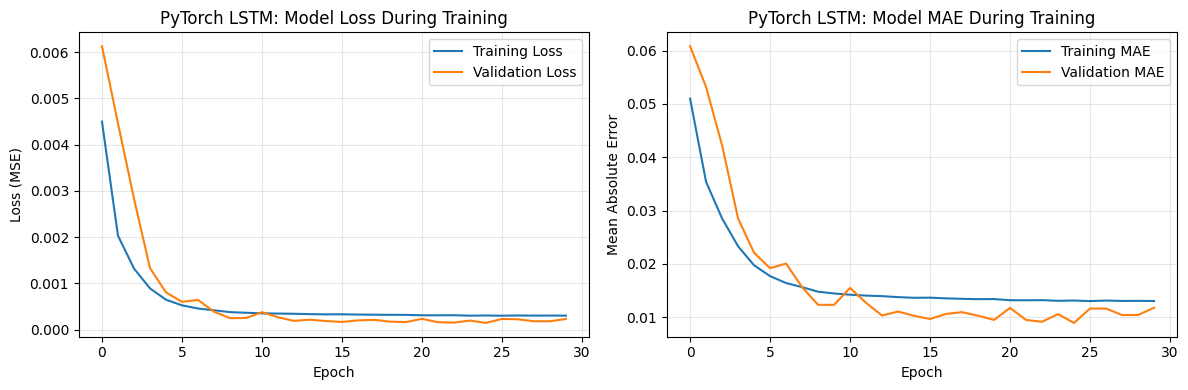

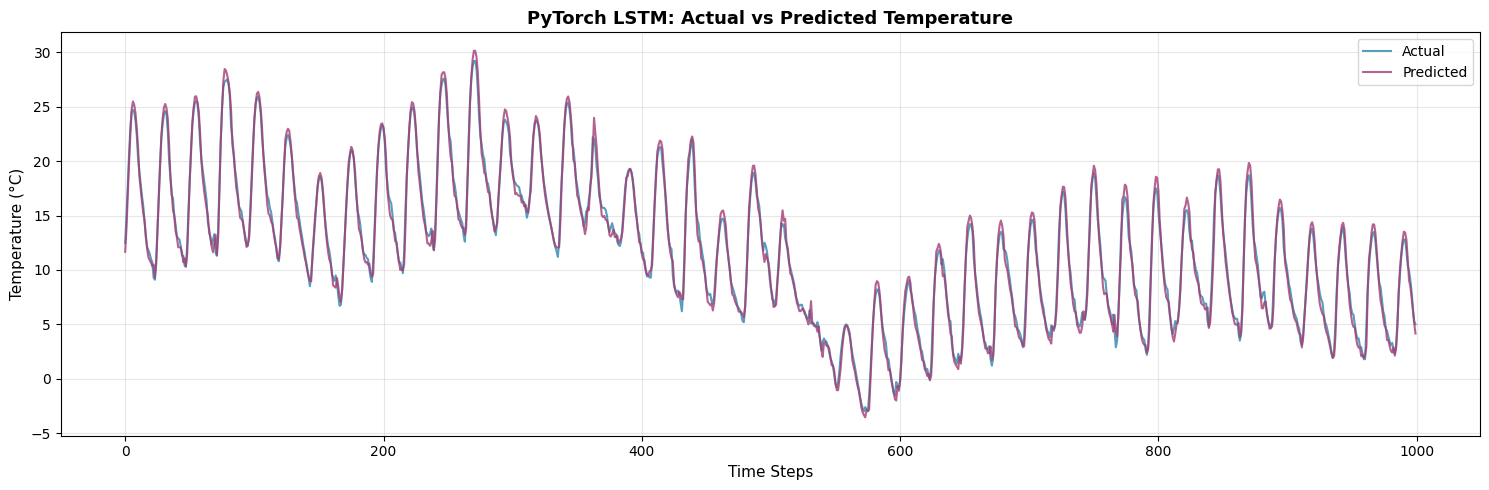

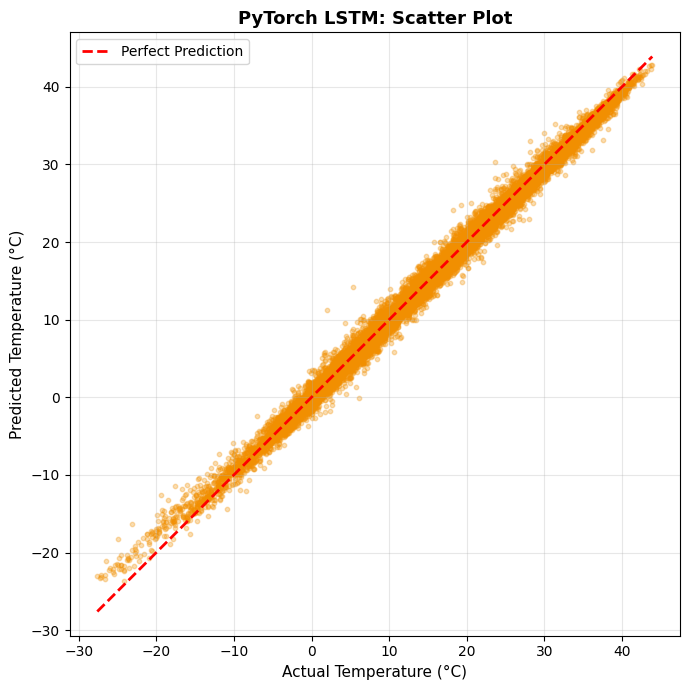


FORECASTING NEXT 48 HOURS
✓ Generated 48 hourly predictions

48-HOUR TEMPERATURE FORECAST

📅 2025-11-24 (Monday)
----------------------------------------------------------------------
  🕐 00:00 (Night       ): 4.1°C
  🕐 06:00 (Morning     ): -1.0°C
  🕐 12:00 (Afternoon   ): 11.2°C
  🕐 18:00 (Sunset      ): 22.5°C

📅 2025-11-25 (Tuesday)
----------------------------------------------------------------------
  🕐 00:00 (Night       ): 11.5°C
  🕐 06:00 (Morning     ): 3.0°C
  🕐 12:00 (Afternoon   ): 8.4°C
  🕐 18:00 (Sunset      ): 29.7°C

✅ PYTORCH LSTM FORECASTING COMPLETE!


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================================================
# CONFIGURATION
# ==========================================================================
API_KEY = '0ea12166dca6efaa2a7077602c59e70d'
BASE_URL = 'https://api.openweathermap.org/data/2.5/'
DATA_PATH = './data/tashkent_weather_15years.csv'

# LSTM Parameters
SEQUENCE_LENGTH = 24  # Use last 24 hours to predict next hour
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
HIDDEN_SIZE = 50
NUM_LAYERS = 2
DROPOUT = 0.2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==========================================================================
# PYTORCH DATASET CLASS
# ==========================================================================

class WeatherDataset(Dataset):
    """Custom PyTorch Dataset for weather time series"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# ==========================================================================
# PYTORCH LSTM MODEL
# ==========================================================================

class WeatherLSTM(nn.Module):
    """
    LSTM Neural Network built from scratch in PyTorch
    
    Architecture:
    - LSTM layers: 2 layers with 50 hidden units each
    - Dropout: 20% between layers
    - Fully connected output layer: 1 unit (temperature)
    """
    
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(WeatherLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get output from last time step
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through fully connected layer
        out = self.fc(out)
        
        return out


# ==========================================================================
# DATA LOADING & PREPROCESSING
# ==========================================================================

def load_weather_data(filepath):
    """Load historical weather data"""
    print("\n" + "="*70)
    print("LOADING WEATHER DATA FOR PYTORCH LSTM MODEL")
    print("="*70)
    
    df = pd.read_csv(filepath)
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    
    print(f"✓ Loaded {len(df):,} rows")
    print(f"✓ Date range: {df['time'].min()} to {df['time'].max()}")
    print(f"✓ Columns: {list(df.columns)}")
    
    return df


def prepare_sequences(data, sequence_length=24):
    """
    Prepare sequences for LSTM training
    Uses sliding window: each sequence is 24 hours, predicts next hour
    """
    print("\n" + "="*70)
    print("PREPARING TIME SERIES SEQUENCES")
    print("="*70)
    
    # Select features
    feature_cols = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 
                    'windspeed_10m', 'windgusts_10m', 'precipitation']
    
    feature_data = data[feature_cols].values
    
    # Normalize to 0-1 range
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(feature_data)
    
    # Create sequences
    X = []
    y = []
    
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])  # Temperature only
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"✓ Created {len(X):,} sequences")
    print(f"✓ Input shape: {X.shape} (samples, timesteps, features)")
    print(f"✓ Output shape: {y.shape}")
    print(f"✓ Sequence length: {sequence_length} hours")
    
    return X, y, scaler, feature_cols


def train_test_split_sequential(X, y, train_ratio=0.8):
    """Split data sequentially for time series"""
    split_idx = int(len(X) * train_ratio)
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    print("\n" + "="*70)
    print("SEQUENTIAL DATA SPLIT (80/20)")
    print("="*70)
    print(f"✓ Training samples: {len(X_train):,} ({train_ratio*100:.0f}%)")
    print(f"✓ Testing samples:  {len(X_test):,} ({(1-train_ratio)*100:.0f}%)")
    
    return X_train, X_test, y_train, y_test


# ==========================================================================
# TRAINING FUNCTIONS
# ==========================================================================

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    """Train PyTorch LSTM model"""
    print("\n" + "="*70)
    print("TRAINING PYTORCH LSTM MODEL")
    print("="*70)
    print(f"Device: {device}")
    
    train_losses = []
    test_losses = []
    train_maes = []
    test_maes = []
    
    best_test_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_mae = 0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            outputs = optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_mae += torch.abs(outputs.squeeze() - y_batch).mean().item()
        
        train_loss /= len(train_loader)
        train_mae /= len(train_loader)
        
        # Validation phase
        model.eval()
        test_loss = 0
        test_mae = 0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                
                test_loss += loss.item()
                test_mae += torch.abs(outputs.squeeze() - y_batch).mean().item()
        
        test_loss /= len(test_loader)
        test_mae /= len(test_loader)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_maes.append(train_mae)
        test_maes.append(test_mae)
        
        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - "
                  f"Train Loss: {train_loss:.6f}, Train MAE: {train_mae:.6f} | "
                  f"Test Loss: {test_loss:.6f}, Test MAE: {test_mae:.6f}")
        
        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_lstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n✓ Early stopping triggered at epoch {epoch+1}")
                # Load best model
                model.load_state_dict(torch.load('best_lstm_model.pth'))
                break
    
    print("\n✓ Training complete!")
    
    history = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'train_mae': train_maes,
        'test_mae': test_maes
    }
    
    return model, history


def evaluate_model(model, X_train, y_train, X_test, y_test, scaler, device):
    """Evaluate model performance with batch processing to avoid OOM"""
    print("\n" + "="*70)
    print("EVALUATING MODEL PERFORMANCE")
    print("="*70)
    
    model.eval()
    
    # Process in batches to avoid memory issues
    batch_size = 1024
    
    # Training predictions
    y_train_pred = []
    with torch.no_grad():
        for i in range(0, len(X_train), batch_size):
            batch = X_train[i:i+batch_size]
            batch_tensor = torch.FloatTensor(batch).to(device)
            pred = model(batch_tensor).cpu().numpy()
            y_train_pred.append(pred)
    y_train_pred = np.vstack(y_train_pred)
    
    # Test predictions
    y_test_pred = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i:i+batch_size]
            batch_tensor = torch.FloatTensor(batch).to(device)
            pred = model(batch_tensor).cpu().numpy()
            y_test_pred.append(pred)
    y_test_pred = np.vstack(y_test_pred)
    
    # Inverse transform
    dummy_train = np.zeros((len(y_train_pred), 6))
    dummy_train[:, 0] = y_train_pred.flatten()
    dummy_test = np.zeros((len(y_test_pred), 6))
    dummy_test[:, 0] = y_test_pred.flatten()
    
    dummy_train_actual = np.zeros((len(y_train), 6))
    dummy_train_actual[:, 0] = y_train
    dummy_test_actual = np.zeros((len(y_test), 6))
    dummy_test_actual[:, 0] = y_test
    
    y_train_pred_actual = scaler.inverse_transform(dummy_train)[:, 0]
    y_test_pred_actual = scaler.inverse_transform(dummy_test)[:, 0]
    y_train_actual = scaler.inverse_transform(dummy_train_actual)[:, 0]
    y_test_actual = scaler.inverse_transform(dummy_test_actual)[:, 0]
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))
    train_mae = mean_absolute_error(y_train_actual, y_train_pred_actual)
    train_r2 = r2_score(y_train_actual, y_train_pred_actual)
    
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
    test_mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
    test_r2 = r2_score(y_test_actual, y_test_pred_actual)
    
    print(f"\n📊 TRAINING METRICS:")
    print(f"  RMSE: {train_rmse:.3f}°C")
    print(f"  MAE:  {train_mae:.3f}°C")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"\n📊 TESTING METRICS:")
    print(f"  RMSE: {test_rmse:.3f}°C")
    print(f"  MAE:  {test_mae:.3f}°C")
    print(f"  R²:   {test_r2:.4f}")
    
    return y_test_actual, y_test_pred_actual


# ==========================================================================
# VISUALIZATION
# ==========================================================================

def plot_training_history(history):
    """Plot training curves"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('PyTorch LSTM: Model Loss During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_mae'], label='Training MAE')
    plt.plot(history['test_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('PyTorch LSTM: Model MAE During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_predictions(y_actual, y_pred):
    """Plot actual vs predicted"""
    plt.figure(figsize=(15, 5))
    
    n = min(1000, len(y_actual))
    x = range(n)
    
    plt.plot(x, y_actual[-n:], label='Actual', linewidth=1.5, alpha=0.8, color='#2E86AB')
    plt.plot(x, y_pred[-n:], label='Predicted', linewidth=1.5, alpha=0.8, color='#A23B72')
    plt.xlabel('Time Steps', fontsize=11)
    plt.ylabel('Temperature (°C)', fontsize=11)
    plt.title('PyTorch LSTM: Actual vs Predicted Temperature', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Scatter
    plt.figure(figsize=(7, 7))
    plt.scatter(y_actual, y_pred, alpha=0.3, s=10, color='#F18F01')
    
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    plt.xlabel('Actual Temperature (°C)', fontsize=11)
    plt.ylabel('Predicted Temperature (°C)', fontsize=11)
    plt.title('PyTorch LSTM: Scatter Plot', fontsize=13, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


# ==========================================================================
# FORECASTING
# ==========================================================================

def forecast_future(model, last_sequence, scaler, device, hours=48):
    """Forecast future temperatures"""
    print("\n" + "="*70)
    print(f"FORECASTING NEXT {hours} HOURS")
    print("="*70)
    
    model.eval()
    predictions = []
    current_sequence = last_sequence.copy()
    
    with torch.no_grad():
        for h in range(hours):
            # Predict
            seq_tensor = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)
            next_pred = model(seq_tensor).cpu().numpy()[0, 0]
            
            # Inverse transform
            dummy = np.zeros((1, 6))
            dummy[0, 0] = next_pred
            temp = scaler.inverse_transform(dummy)[0, 0]
            
            predictions.append(temp)
            
            # Update sequence
            new_row = current_sequence[-1].copy()
            new_row[0] = next_pred
            current_sequence = np.vstack([current_sequence[1:], new_row])
    
    print(f"✓ Generated {len(predictions)} hourly predictions")
    return predictions


def display_forecast(predictions, start_time):
    """Display forecast"""
    print("\n" + "="*70)
    print("48-HOUR TEMPERATURE FORECAST")
    print("="*70)
    
    current_date = None
    
    for i, temp in enumerate(predictions):
        forecast_time = start_time + timedelta(hours=i+1)
        
        if forecast_time.date() != current_date:
            current_date = forecast_time.date()
            print(f"\n📅 {current_date.strftime('%Y-%m-%d (%A)')}")
            print("-" * 70)
        
        hour_str = forecast_time.strftime('%H:%M')
        
        if forecast_time.hour in [6, 12, 18, 0]:
            period = {6: "Morning", 12: "Afternoon", 18: "Sunset", 0: "Night"}[forecast_time.hour]
            print(f"  🕐 {hour_str} ({period:12s}): {temp:.1f}°C")


# ==========================================================================
# MAIN EXECUTION
# ==========================================================================

def main():
    """Main execution"""
    print("\n" + "="*70)
    print(" " * 12 + "PYTORCH LSTM TIME SERIES WEATHER FORECASTING")
    print(" " * 18 + "Sequential Model (From Scratch)")
    print("="*70)
    
    # Load data
    df = load_weather_data(DATA_PATH)
    
    # Prepare sequences
    X, y, scaler, feature_cols = prepare_sequences(df, SEQUENCE_LENGTH)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split_sequential(X, y)
    
    # Create datasets and loaders
    train_dataset = WeatherDataset(X_train, y_train)
    test_dataset = WeatherDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Build model
    print("\n" + "="*70)
    print("BUILDING PYTORCH LSTM MODEL")
    print("="*70)
    
    input_size = X_train.shape[2]
    model = WeatherLSTM(input_size, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
    
    print(f"✓ Model built successfully!")
    print(f"  Input size: {input_size} features")
    print(f"  Hidden size: {HIDDEN_SIZE}")
    print(f"  Num layers: {NUM_LAYERS}")
    print(f"  Dropout: {DROPOUT}")
    print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Train
    model, history = train_model(model, train_loader, test_loader, criterion, optimizer, EPOCHS, device)
    
    # Evaluate
    y_test_actual, y_test_pred = evaluate_model(model, X_train, y_train, X_test, y_test, scaler, device)
    
    # Visualize
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70)
    
    plot_training_history(history)
    plot_predictions(y_test_actual, y_test_pred)
    
    # Forecast
    last_sequence = X[-1]
    predictions = forecast_future(model, last_sequence, scaler, device, hours=48)
    
    last_time = df['time'].max()
    display_forecast(predictions, last_time)
    
    print("\n" + "="*70)
    print("✅ PYTORCH LSTM FORECASTING COMPLETE!")
    print("="*70)
    
    return model, scaler, history


if __name__ == "__main__":
    model, scaler, history = main()

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# ==========================================================================
# MODEL COMPARISON FRAMEWORK
# ==========================================================================

class ModelComparison:
    """
    Compare multiple weather prediction models
    Metrics: RMSE, MAE, R², MAPE, Training Time, Prediction Speed
    """
    
    def __init__(self):
        self.results = []
        self.models_data = {}
        
    def add_model_result(self, model_name, y_true, y_pred, train_time, test_time, model_info=None):
        """
        Add a model's results for comparison
        
        Parameters:
        - model_name: str, name of the model
        - y_true: actual temperature values
        - y_pred: predicted temperature values
        - train_time: training time in seconds
        - test_time: prediction time in seconds
        - model_info: dict with additional model details
        """
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # in percentage
        
        # Calculate error statistics
        errors = y_true - y_pred
        error_std = np.std(errors)
        max_error = np.max(np.abs(errors))
        
        result = {
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape,
            'Error Std': error_std,
            'Max Error': max_error,
            'Train Time (s)': train_time,
            'Test Time (s)': test_time,
            'Samples': len(y_true)
        }
        
        if model_info:
            result.update(model_info)
        
        self.results.append(result)
        self.models_data[model_name] = {
            'y_true': y_true,
            'y_pred': y_pred,
            'errors': errors
        }
        
        print(f"✓ Added {model_name} results")
    
    def get_comparison_table(self):
        """Get comparison table as DataFrame"""
        df = pd.DataFrame(self.results)
        
        # Sort by RMSE (lower is better)
        df = df.sort_values('RMSE')
        
        return df
    
    def display_comparison(self):
        """Display detailed comparison"""
        print("\n" + "="*100)
        print(" " * 35 + "MODEL COMPARISON RESULTS")
        print("="*100)
        
        df = self.get_comparison_table()
        
        # Accuracy Metrics
        print("\n📊 ACCURACY METRICS (Lower is Better for RMSE, MAE, MAPE | Higher is Better for R²)")
        print("-"*100)
        
        metrics_df = df[['Model', 'RMSE', 'MAE', 'R²', 'MAPE']].copy()
        
        # Highlight best values
        best_rmse = metrics_df['RMSE'].min()
        best_mae = metrics_df['MAE'].min()
        best_r2 = metrics_df['R²'].max()
        best_mape = metrics_df['MAPE'].min()
        
        for idx, row in metrics_df.iterrows():
            model = row['Model']
            rmse_marker = " ⭐ BEST" if row['RMSE'] == best_rmse else ""
            mae_marker = " ⭐ BEST" if row['MAE'] == best_mae else ""
            r2_marker = " ⭐ BEST" if row['R²'] == best_r2 else ""
            mape_marker = " ⭐ BEST" if row['MAPE'] == best_mape else ""
            
            print(f"\n{model}:")
            print(f"  RMSE: {row['RMSE']:.4f}°C{rmse_marker}")
            print(f"  MAE:  {row['MAE']:.4f}°C{mae_marker}")
            print(f"  R²:   {row['R²']:.6f}{r2_marker}")
            print(f"  MAPE: {row['MAPE']:.2f}%{mape_marker}")
        
        # Performance Metrics
        print("\n\n⚡ PERFORMANCE METRICS")
        print("-"*100)
        
        perf_df = df[['Model', 'Train Time (s)', 'Test Time (s)', 'Samples']].copy()
        
        for idx, row in perf_df.iterrows():
            print(f"\n{row['Model']}:")
            print(f"  Training Time:   {row['Train Time (s)']:.2f}s")
            print(f"  Testing Time:    {row['Test Time (s)']:.4f}s")
            print(f"  Samples/Second:  {row['Samples']/row['Test Time (s)']:.0f}")
        
        # Overall Ranking
        print("\n\n🏆 OVERALL RANKING")
        print("-"*100)
        
        # Normalize metrics for ranking (0-1 scale)
        df_rank = df.copy()
        
        # For metrics where lower is better
        df_rank['RMSE_norm'] = 1 - (df_rank['RMSE'] - df_rank['RMSE'].min()) / (df_rank['RMSE'].max() - df_rank['RMSE'].min() + 1e-10)
        df_rank['MAE_norm'] = 1 - (df_rank['MAE'] - df_rank['MAE'].min()) / (df_rank['MAE'].max() - df_rank['MAE'].min() + 1e-10)
        df_rank['MAPE_norm'] = 1 - (df_rank['MAPE'] - df_rank['MAPE'].min()) / (df_rank['MAPE'].max() - df_rank['MAPE'].min() + 1e-10)
        
        # For R² where higher is better (already 0-1)
        df_rank['R2_norm'] = df_rank['R²']
        
        # Calculate overall score (equal weight)
        df_rank['Overall Score'] = (df_rank['RMSE_norm'] + df_rank['MAE_norm'] + 
                                     df_rank['R2_norm'] + df_rank['MAPE_norm']) / 4
        
        df_rank = df_rank.sort_values('Overall Score', ascending=False)
        
        for rank, (idx, row) in enumerate(df_rank.iterrows(), 1):
            medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
            print(f"\n{medal} {row['Model']}")
            print(f"   Overall Score: {row['Overall Score']:.4f}")
            print(f"   RMSE: {row['RMSE']:.4f}°C | MAE: {row['MAE']:.4f}°C | R²: {row['R²']:.6f} | MAPE: {row['MAPE']:.2f}%")
        
        # Recommendation
        best_model = df_rank.iloc[0]['Model']
        print(f"\n\n✅ RECOMMENDATION: Use {best_model} for best overall performance")
        
        return df
    
    def plot_comparison(self):
        """Create comprehensive comparison visualizations"""
        if len(self.results) < 2:
            print("⚠ Need at least 2 models to compare")
            return
        
        df = self.get_comparison_table()
        models = df['Model'].tolist()
        
        # Create figure with subplots
        fig = plt.figure(figsize=(18, 12))
        
        # 1. Accuracy Metrics Comparison
        ax1 = plt.subplot(3, 3, 1)
        ax1.bar(models, df['RMSE'], color='#FF6B6B', alpha=0.7)
        ax1.set_ylabel('RMSE (°C)')
        ax1.set_title('Root Mean Squared Error\n(Lower is Better)', fontweight='bold')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(axis='y', alpha=0.3)
        
        ax2 = plt.subplot(3, 3, 2)
        ax2.bar(models, df['MAE'], color='#4ECDC4', alpha=0.7)
        ax2.set_ylabel('MAE (°C)')
        ax2.set_title('Mean Absolute Error\n(Lower is Better)', fontweight='bold')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(axis='y', alpha=0.3)
        
        ax3 = plt.subplot(3, 3, 3)
        ax3.bar(models, df['R²'], color='#95E1D3', alpha=0.7)
        ax3.set_ylabel('R² Score')
        ax3.set_title('R² Score\n(Higher is Better)', fontweight='bold')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(axis='y', alpha=0.3)
        ax3.set_ylim([0, 1])
        
        # 2. Error Distribution Comparison
        ax4 = plt.subplot(3, 3, 4)
        for model_name in models:
            errors = self.models_data[model_name]['errors']
            ax4.hist(errors, bins=50, alpha=0.5, label=model_name, edgecolor='black')
        ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
        ax4.set_xlabel('Prediction Error (°C)')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Error Distribution Comparison', fontweight='bold')
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # 3. Box Plot of Errors
        ax5 = plt.subplot(3, 3, 5)
        error_data = [self.models_data[m]['errors'] for m in models]
        bp = ax5.boxplot(error_data, labels=models, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('#FFD93D')
        ax5.axhline(y=0, color='r', linestyle='--', linewidth=1)
        ax5.set_ylabel('Prediction Error (°C)')
        ax5.set_title('Error Distribution (Box Plot)', fontweight='bold')
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(axis='y', alpha=0.3)
        
        # 4. Actual vs Predicted Scatter (Last 500 points)
        ax6 = plt.subplot(3, 3, 6)
        colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFD93D', '#C7CEEA']
        for idx, model_name in enumerate(models):
            y_true = self.models_data[model_name]['y_true'][-500:]
            y_pred = self.models_data[model_name]['y_pred'][-500:]
            ax6.scatter(y_true, y_pred, alpha=0.4, s=20, label=model_name, color=colors[idx % len(colors)])
        
        min_val = min([self.models_data[m]['y_true'].min() for m in models])
        max_val = max([self.models_data[m]['y_true'].max() for m in models])
        ax6.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')
        ax6.set_xlabel('Actual Temperature (°C)')
        ax6.set_ylabel('Predicted Temperature (°C)')
        ax6.set_title('Actual vs Predicted (Last 500 points)', fontweight='bold')
        ax6.legend()
        ax6.grid(alpha=0.3)
        
        # 5. Time Series Comparison (Last 200 points)
        ax7 = plt.subplot(3, 3, 7)
        n = 200
        x = range(n)
        # Plot actual (use first model's y_true)
        y_actual = self.models_data[models[0]]['y_true'][-n:]
        ax7.plot(x, y_actual, 'k-', linewidth=2, label='Actual', alpha=0.7)
        
        for idx, model_name in enumerate(models):
            y_pred = self.models_data[model_name]['y_pred'][-n:]
            ax7.plot(x, y_pred, '--', linewidth=1.5, label=model_name, alpha=0.7, color=colors[idx % len(colors)])
        
        ax7.set_xlabel('Time Steps')
        ax7.set_ylabel('Temperature (°C)')
        ax7.set_title('Predictions Comparison (Last 200 points)', fontweight='bold')
        ax7.legend()
        ax7.grid(alpha=0.3)
        
        # 6. Performance Metrics
        ax8 = plt.subplot(3, 3, 8)
        x_pos = np.arange(len(models))
        ax8.bar(x_pos - 0.2, df['Train Time (s)'], 0.4, label='Train Time', color='#FF6B6B', alpha=0.7)
        ax8.bar(x_pos + 0.2, df['Test Time (s)'], 0.4, label='Test Time', color='#4ECDC4', alpha=0.7)
        ax8.set_ylabel('Time (seconds)')
        ax8.set_title('Training & Testing Time', fontweight='bold')
        ax8.set_xticks(x_pos)
        ax8.set_xticklabels(models, rotation=45)
        ax8.legend()
        ax8.grid(axis='y', alpha=0.3)
        
        # 7. MAPE Comparison
        ax9 = plt.subplot(3, 3, 9)
        ax9.bar(models, df['MAPE'], color='#C7CEEA', alpha=0.7)
        ax9.set_ylabel('MAPE (%)')
        ax9.set_title('Mean Absolute Percentage Error\n(Lower is Better)', fontweight='bold')
        ax9.tick_params(axis='x', rotation=45)
        ax9.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Comparison visualizations generated!")
    
    def export_results(self, filename='model_comparison_results.csv'):
        """Export comparison results to CSV"""
        df = self.get_comparison_table()
        df.to_csv(filename, index=False)
        print(f"✅ Results exported to {filename}")
        return df


# ==========================================================================
# HELPER FUNCTION TO RUN COMPARISON
# ==========================================================================

def compare_models(linear_reg_results, tensorflow_lstm_results, pytorch_lstm_results):
    """
    Compare all three models
    
    Parameters:
    Each result should be a dict with:
    - 'y_true': actual values
    - 'y_pred': predicted values
    - 'train_time': training time in seconds
    - 'test_time': testing time in seconds
    - 'model_info': optional dict with model details
    """
    
    comparison = ModelComparison()
    
    # Add Linear Regression results
    comparison.add_model_result(
        model_name="Linear Regression",
        y_true=linear_reg_results['y_true'],
        y_pred=linear_reg_results['y_pred'],
        train_time=linear_reg_results['train_time'],
        test_time=linear_reg_results['test_time'],
        model_info=linear_reg_results.get('model_info', {})
    )
    
    # Add TensorFlow LSTM results
    comparison.add_model_result(
        model_name="TensorFlow LSTM",
        y_true=tensorflow_lstm_results['y_true'],
        y_pred=tensorflow_lstm_results['y_pred'],
        train_time=tensorflow_lstm_results['train_time'],
        test_time=tensorflow_lstm_results['test_time'],
        model_info=tensorflow_lstm_results.get('model_info', {})
    )
    
    # Add PyTorch LSTM results
    comparison.add_model_result(
        model_name="PyTorch LSTM",
        y_true=pytorch_lstm_results['y_true'],
        y_pred=pytorch_lstm_results['y_pred'],
        train_time=pytorch_lstm_results['train_time'],
        test_time=pytorch_lstm_results['test_time'],
        model_info=pytorch_lstm_results.get('model_info', {})
    )
    
    # Display comparison
    results_df = comparison.display_comparison()
    
    # Plot comparison
    comparison.plot_comparison()
    
    # Export results
    comparison.export_results()
    
    return comparison, results_df


# ==========================================================================
# EXAMPLE USAGE
# ==========================================================================

if __name__ == "__main__":
    print("""
    ================================================================================
                            MODEL COMPARISON FRAMEWORK
    ================================================================================
    
    This framework compares weather prediction models across multiple metrics:
    
    📊 Accuracy Metrics:
       - RMSE (Root Mean Squared Error) - Lower is better
       - MAE (Mean Absolute Error) - Lower is better
       - R² Score - Higher is better (0-1 scale)
       - MAPE (Mean Absolute Percentage Error) - Lower is better
    
    ⚡ Performance Metrics:
       - Training Time
       - Testing/Prediction Time
       - Samples per Second
    
    📈 Visualizations:
       - Error distributions
       - Actual vs Predicted scatter plots
       - Time series comparisons
       - Performance comparisons
    
    ================================================================================
    
    USAGE:
    
    After running each model separately, collect results in this format:
    
    linear_reg_results = {
        'y_true': y_test_actual,
        'y_pred': y_test_pred,
        'train_time': training_time_seconds,
        'test_time': testing_time_seconds,
        'model_info': {'features': 27, 'type': 'Linear'}
    }
    
    Then call:
    comparison, results_df = compare_models(linear_reg_results, 
                                            tensorflow_lstm_results, 
                                            pytorch_lstm_results)
    ================================================================================
    """)


                            MODEL COMPARISON FRAMEWORK

    This framework compares weather prediction models across multiple metrics:

    📊 Accuracy Metrics:
       - RMSE (Root Mean Squared Error) - Lower is better
       - MAE (Mean Absolute Error) - Lower is better
       - R² Score - Higher is better (0-1 scale)
       - MAPE (Mean Absolute Percentage Error) - Lower is better

    ⚡ Performance Metrics:
       - Training Time
       - Testing/Prediction Time
       - Samples per Second

    📈 Visualizations:
       - Error distributions
       - Actual vs Predicted scatter plots
       - Time series comparisons
       - Performance comparisons


    USAGE:

    After running each model separately, collect results in this format:

    linear_reg_results = {
        'y_true': y_test_actual,
        'y_pred': y_test_pred,
        'train_time': training_time_seconds,
        'test_time': testing_time_seconds,
        'model_info': {'features': 27, 'type': 'Linear'}
    }

    Then c